In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Provision 737 Camera Data Pre-Processing

In [3]:
# Benign traffic

p7_benign = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)

columns = list(df_p7_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)  

# Mirai

p7_mirai_ack = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_p7_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_p7_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_p7_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_p7_miraiack_norm
X_test_mirai_scan = df_p7_miraiscan_norm
X_test_mirai_syn = df_p7_miraisyn_norm
X_test_mirai_udp = df_p7_miraiudp_norm
X_test_mirai_udpplain = df_p7_miraiudpplain_norm
X_test_bashlite_combo = df_p7_bashlitecombo_norm
X_test_bashlite_junk = df_p7_bashlitejunk_norm
X_test_bashlite_scan = df_p7_bashlitescan_norm
X_test_bashlite_tcp = df_p7_bashlitetcp_norm
X_test_bashlite_udp = df_p7_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 300
learning_rate = 0.0001
batch_size = 32
anomaly_threshold = 0.035
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11)           264         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            84          dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 7)            84          dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                88        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                276       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 23)]              0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 432       
_________________________________________________________________
decoder (Functional)         (None, 23)                364       
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 43507 samples
Epoch 1/300
43507/43507 [==============================] - 4s 84us/sample - loss: 101.9014
Epoch 2/300
43507/43507 [==============================] - 3s 79us/sample - loss: 23.9072
Epoch 3/300
43507/43507 [==============================] - 3s 79us/sample - loss: 10.8681
Epoch 4/300
43507/43507 [==============================] - 3s 79us/sample - loss: 8.5266
Epoch 5/300
43507/43507 [==============================] - 3s 79us/sample - loss: 7.6279
Epoch 6/300
43507/43507 [==============================] - 3s 79us/sample - loss: 6.9852
Epoch 7/300
43507/43507 [==============================] - 3s 79us/sample - loss: 6.3196
Epoch 8/300
43507/43507 [==============================] - 3s 79us/sample - loss: 5.6952
Epoch 9/300
43507/43507 [==============================] - 3s 78us/sample - loss: 5.2075
Epoch 10/300
43507/43507 [==============================] - 3s 79us/sample - loss: 4.8810
Epoch 11/300
43507/43507 [==============================] - 3s 79us/sample - loss:

43507/43507 [==============================] - 3s 74us/sample - loss: 2.3272
Epoch 92/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3597
Epoch 93/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3317
Epoch 94/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3333
Epoch 95/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3301
Epoch 96/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3354
Epoch 97/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3199
Epoch 98/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3263
Epoch 99/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3060
Epoch 100/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3061
Epoch 101/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.2990
Epoch 102/300
43507/4

43507/43507 [==============================] - 3s 80us/sample - loss: 2.2793
Epoch 182/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2876
Epoch 183/300
43507/43507 [==============================] - 3s 80us/sample - loss: 2.3076
Epoch 184/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2757
Epoch 185/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2626
Epoch 186/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2945
Epoch 187/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2727
Epoch 188/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2887
Epoch 189/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.2793
Epoch 190/300
43507/43507 [==============================] - 3s 79us/sample - loss: 2.3112
Epoch 191/300
43507/43507 [==============================] - 3s 80us/sample - loss: 2.3095
Epoch 192/300

43507/43507 [==============================] - 3s 73us/sample - loss: 2.3078
Epoch 272/300
43507/43507 [==============================] - 3s 74us/sample - loss: 2.3090
Epoch 273/300
43507/43507 [==============================] - 3s 75us/sample - loss: 2.3138
Epoch 274/300
43507/43507 [==============================] - 3s 62us/sample - loss: 2.2927
Epoch 275/300
43507/43507 [==============================] - 3s 62us/sample - loss: 2.2882
Epoch 276/300
43507/43507 [==============================] - 3s 59us/sample - loss: 2.2845
Epoch 277/300
43507/43507 [==============================] - 3s 61us/sample - loss: 2.2915
Epoch 278/300
43507/43507 [==============================] - 3s 61us/sample - loss: 2.2823
Epoch 279/300
43507/43507 [==============================] - 3s 61us/sample - loss: 2.2768
Epoch 280/300
43507/43507 [==============================] - 3s 61us/sample - loss: 2.3065
Epoch 281/300
43507/43507 [==============================] - 3s 61us/sample - loss: 2.2525
Epoch 282/300

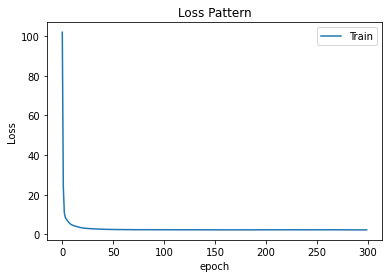

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
#np.quantile(error_vector, anomaly_threshold)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.035


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 27.525400161743164
[False False False ...  True  True  True]


0.9791654189279939

In [15]:
print(len(X_test_VAE))

784753


## Metrics

In [16]:
sys.stdout = open("Results/P737_camera.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'